In [2]:
"https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"
"https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html"

import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim

#Visualizations
#import plotly.express as px
#import seaborn as sns
#import pyLDAvis.gensim
#import chart_studio
#import chart_studio.plotly as py 
#import chart_studio.tools as tls

plt.style.use('seaborn')

#data_path = "data/santiago_covid_2020.csv"
#data_path = "data/santiago_enero.csv"
data_path = "data/gabrielboric.csv"



# spanish stop words
stop_words = set(stopwords.words('spanish'))
stop_words = ['t', 'si', 'q', 'https', 'co', 'solo', 'ser', 'bien', 
            'así', 'ma', 'mas', 'igual', 'va', 'después',
            'hacer', 'hace', 'creo'] + list(stop_words)

C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# **Métodos útiles**

In [33]:
def bar_plot(x, y, title, file_name):
    """useful method to generate and save bar plots.

    Args:
        x (str, float?): names.
        y (float): value of each name.
        title (str): title to put on the plot.
        file_name (str): fiel name to save the plot
    """
    plt.bar(x, y)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.savefig("imgs/segunda_avance/" + file_name)
    plt.show()

def delete_chars(text, unwanted_chars):
    """
    useful method to replace a list of chars on text.
    return:
        (str) the same str without the chars in chars.
    """
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

def preprocess_tweet(tweet):
    """
    Replaces unwanted characters and performs
    a preprocessing.
    input: 
        (str) tweet.
    return:
        (str[]) final: list of words.
    """
    unwanted = ['#', ',', '.', '!', '?', '¿', '¡', '(',\
                ')', '-', '=', 'jaja', 'jajaja']
    final = delete_chars(tweet, unwanted).split()
    final = [w.lower() for w in final]
    final = [w for w in final if w not in stop_words and len(w) > 3]
    # Se eliminan links y @users
    final = [w for w in final if w[:4] != 'http']
    final = [w for w in final if w[:1] != '@']
    return final
    
# mini mini test
print(preprocess_tweet('##hola) ¿chao? =) jaja!'))


['hola', 'chao']


# **Tweets**

In [4]:
data = pd.read_csv(data_path)[['date', 'tweet']]
print('---------------------------------------------------------')
print('Sample: ', data.iloc[0]['tweet'])
print('---------------------------------------------------------')
print('Cantidad de tweets: ', len(data))
print('---------------------------------------------------------')

---------------------------------------------------------
Sample:  Hoy nos reunimos con el Rector de la @uvalpochile @ocorralesj para conversar sobre educación superior y los desafíos de las universidades estatales para el nuevo Chile. Nuestro gobierno buscará fortalecer la #educación pública de calidad.  https://t.co/aXvXMWoNPx
---------------------------------------------------------
Cantidad de tweets:  39405
---------------------------------------------------------


C:\Users\jigna\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (9,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
preprocess_tweet(data.iloc[0]['tweet'])

['reunimos',
 'rector',
 'conversar',
 'educación',
 'superior',
 'desafíos',
 'universidades',
 'estatales',
 'nuevo',
 'chile',
 'gobierno',
 'buscará',
 'fortalecer',
 'educación',
 'pública',
 'calidad']

# **Preprocess**

In [46]:
# Se pre-procesan los tweets: Esto transforma cada
# tweet en una colección de palabras.
# processed_tweets corresponde a una lista de listas de palabras.

processed_tweets = data['tweet'].map(preprocess_tweet)
processed_tweets.head()

# Se van a eliminar tweets pequeños: con menos de 5 palabras después
# del preprocessing.
dropers = []
for ind, tweet in enumerate(processed_tweets):
    if len(tweet) < 5:
        dropers.append(ind) 

processed_tweets = processed_tweets.drop(dropers)
print(processed_tweets.sample(5))

print("-----------------------------------------------------------------")
print('Cantidad de tweets resultantes: ', len(processed_tweets))

1306     [sido, freno, clave, participación, politica, ...
876      [obsesión, gobierno, argumentar, excepción, re...
35696    [comité, disciplinario, partido, movido, envid...
11241    [declaración, principios, sigue, piñera, probl...
7614     [diputado, dice, propuesta, bajar, sueldos, pa...
Name: tweet, dtype: object
-----------------------------------------------------------------
Cantidad de tweets resultantes:  20902


In [7]:
# Se crea el vocabulario. 
# Corresponde a crear una lista con todas las palabras involucrada 
# en el corpus asignando un índice único a cada una.

dictionary = gensim.corpora.Dictionary(processed_tweets)

# Se quitan palabras que aparecen en menos de 20 tweets y las
# que aparecen en más del 50% del total de tweets (?).
dictionary.filter_extremes(no_below=20, no_above=0.5)

c = 0
for k, v in dictionary.iteritems():
    print(k,v)
    c += 1
    if c > 5: break
        
print('Largo del diccionario: ', len(dictionary))

0 calidad
1 chile
2 conversar
3 desafíos
4 educación
5 estatales
Largo del diccionario:  1853


In [8]:
# Se transforman las palabras a vectores con el dictionary.
# bow = "bag of words"

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_tweets]
print('tweet 0: ', bow_corpus[0])
print('tweet 1: ', bow_corpus[1])

# Con esto cada tweet se representa como una colección de tuplas (w, a) 
# donde w es el índice de la palabra y a la cantidad de apariciones en ese
# tweet.

tweet 0:  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
tweet 1:  [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


# **Boric0**

In [9]:
# Se crea y usa el lda model
# Running LDA using Bag of Words

# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary#.id2token

lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=1
)
# LdaMulticore


In [10]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.031*"chile" + 0.018*"abrazo" + 0.016*"gracias" + 0.016*"buena" + 0.015*"estudiantes" + 0.014*"izquierda" + 0.014*"fech" + 0.013*"recomiendo" + 0.011*"fuerza" + 0.011*"columna"
Topic: 1 
Words: 0.030*"política" + 0.022*"acuerdo" + 0.019*"gobierno" + 0.017*"puede" + 0.013*"parte" + 0.013*"problema" + 0.012*"debe" + 0.011*"mismo" + 0.010*"cierto" + 0.010*"dice"
Topic: 2 
Words: 0.046*"ahora" + 0.037*"magallanes" + 0.027*"vamos" + 0.022*"mañana" + 0.021*"arenas" + 0.020*"punta" + 0.016*"universidad" + 0.016*"vivo" + 0.014*"campaña" + 0.014*"movimiento"
Topic: 3 
Words: 0.043*"educación" + 0.021*"proyecto" + 0.020*"senado" + 0.018*"debate" + 0.017*"comisión" + 0.016*"comparto" + 0.014*"trabajadores" + 0.014*"estudiantil" + 0.014*"lucro" + 0.013*"reforma"
Topic: 4 
Words: 0.033*"derecha" + 0.021*"saludos" + 0.018*"parece" + 0.017*"caso" + 0.015*"nueva" + 0.015*"alguien" + 0.013*"mayoría" + 0.012*"proceso" + 0.010*"partidos" + 0.010*"quiere"


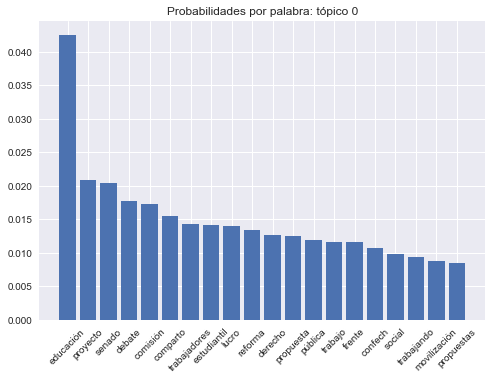

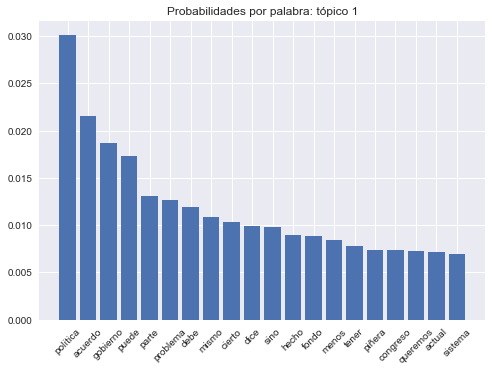

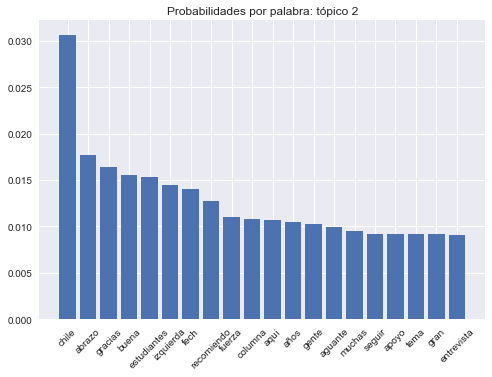

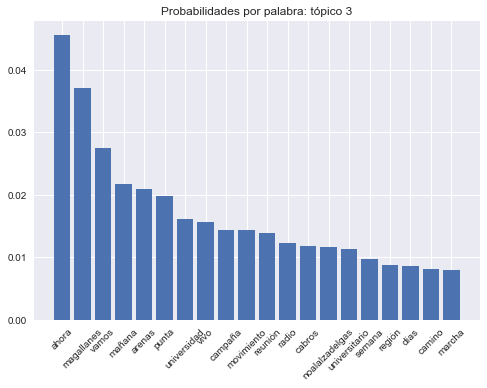

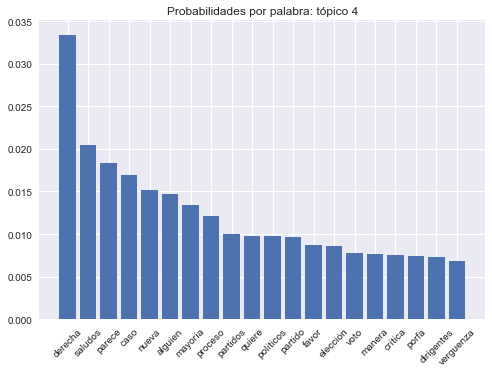

'\nplt.bar(words, probs)\nplt.xticks(rotation=45)\nplt.show()\n'

In [34]:
# Acá se generan bar plots de las probabilidades de cada palabra en los
# tópicos obtenidos.

# top_topics es un arreglo de tamaño el número de tópicos, cada elemento 
# de este arreglo es una tupla (arr, co) donde co es el valor de coherencia
# de cada tópico y arr es un arreglo de tuplas (prob, word) con la probab
# de cada palabra en el tópico. 

from pprint import pprint

top_topics = lda_model.top_topics(bow_corpus)#, num_words=20)

def bar_plot_boric():
    # Correr sólo para generar y guardar plots.
    for ind, t in enumerate(top_topics):
        bar_plot([x[1] for x in t[0]], [x[0] for x in t[0]], \
                "Probabilidades por palabra: tópico {}".format(ind), \
                "boric_barplot{}.png".format(ind))


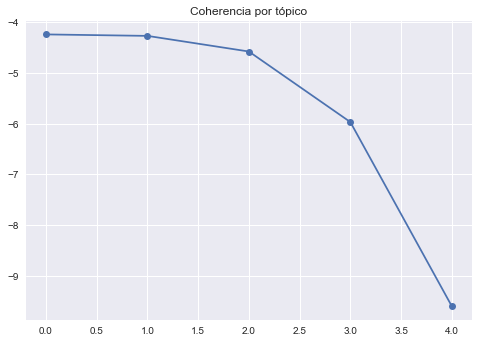

In [40]:
# Acá graficamos la coherencia por tópico.

plt.plot(range(len(top_topics)), [t[1] for t in top_topics], 'o-')
plt.title("Coherencia por tópico")
#plt.savefig("imgs/segunda_avance/boric_topic_coherence.png")
plt.show()

In [43]:
# Acá vamos a obtener el parámetro que guarda las probabilidades de cada tópico.
lda_model.get_topic_terms(0)

[(1, 0.030664915),
 (15, 0.017732922),
 (99, 0.016395025),
 (293, 0.0155617995),
 (151, 0.01532473),
 (976, 0.014429897),
 (1409, 0.014051646),
 (479, 0.0127690425),
 (1091, 0.0110285925),
 (719, 0.010800995)]

In [12]:
# Visualizar:

#pyLDAvis.enable_notebook()
#pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
#from gensim.models import CoherenceModel
# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_tweets, dictionary=dictionary, coherence='c_v')
#coherence_model_lda.get_coherence()